Finding the ratio of interaction rates between singles and binaries

In [19]:
import glob; import sys; import os
import pandas as pd
import functions
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
from matplotlib.lines import Line2D


pd.options.mode.chained_assignment = None
plt.rcParams.update({'font.size': 20}) # Set a good font size

# Defining constants
G = 1.908e5 # R_sol*(M_sol)^-1*km^2*s^-2 
pc2AU = 206265 # Pc -> AU
Rsol2AU = 0.00465047 # Rsol -> AU
pcMyr2kms = 1.023 # Pc/Myr -> km/s

In [20]:
dataDir = functions.get_Started()

Possible Directories:

0 : COMPAS_Output_1%sol_fallback
1 : COMPAS_Output_1%sol_noKicks
2 : COMPAS_Output_1%sol_reduced
3 : COMPAS_Output_1%_correctedEVO
4 : COMPAS_Output_1%_no_CHE
5 : COMPAS_Output_1%_pessCHE
6 : COMPAS_Output_largea_detailed
7 : COMPAS_Output_largea_detailed2
8 : COMPAS_Output_noBHKick_Z0.0001
9 : COMPAS_Output_noBHKick_Z0.001
10 : COMPAS_Output_noChem
11 : COMPAS_Output_PeTar_M100000
12 : COMPAS_Output_smalla_detailed
13 : COMPAS_Output_smalla_detailed2
14 : COMPAS_Output_sol_correctEVO
15 : COMPAS_Output_sol_no_CHE
16 : COMPAS_Output_SSE_Z0.00015
17 : COMPAS_Output_SSE_Z0.0015
18 : COMPAS_Output_test
19 : COMPAS_Output_test2
20 : COMPAS_Output_Z0.0001
21 : COMPAS_Output_Z0.00015
22 : COMPAS_Output_Z0.0005
23 : COMPAS_Output_Z0.00075
24 : COMPAS_Output_Z0.001
25 : COMPAS_Output_Z0.0015
26 : COMPAS_Output_Z0.005
27 : COMPAS_Output_Z0.0075
28 : COMPAS_Output_Z0.01
29 : COMPAS_Output_Z0.01_varied



What directory is the data stored in?    20


In [21]:
# Load in the double compact objects as well as the system parameters
DCO = pd.read_csv(os.path.join(dataDir, 'BSE_Double_Compact_Objects.csv'), skiprows=2)
SP = pd.read_csv(os.path.join(dataDir, 'BSE_System_Parameters.csv'), skiprows=2)
SN = pd.read_csv(os.path.join(dataDir, 'BSE_Supernovae.csv'), skiprows=2)


# Find the equilibrated at birth and remove them from the DCOs
EAB = SP.loc[SP['Equilibrated_At_Birth']==1] 
DCO.drop(DCO.loc[DCO['    SEED    '].isin(EAB['    SEED    '])].index, inplace=True)
SN.drop(SN.loc[SN['    SEED    '].isin(EAB['    SEED    '])].index, inplace=True)


# Specifically grab the BBHs
BBHMaster = DCO.loc[(DCO['Stellar_Type(1)']==14)&(DCO['Stellar_Type(2)']==14)].copy()
BBHMaster.reset_index(inplace=True, drop=True)


# For now I am dropping any binaries with a>1e6
BBHMaster = BBHMaster.loc[BBHMaster['SemiMajorAxis@DCO']<1e6]

In [22]:
'''
Here we find all of the possible BH systems so that we can 
later find which have been retained.
'''

# Index for both SNs , only first and only last
SNDupIndex = SN.duplicated(subset='    SEED    ', keep=False)

SN1st = SN.loc[SN.duplicated(subset='    SEED    ', keep='last')]
SN2nd = SN.loc[SN.duplicated(subset='    SEED    ', keep='first')]

SN1st.reset_index(drop=True, inplace=True)
SN2nd.reset_index(drop=True, inplace=True)

# Two SNs
SNDup = SN.loc[SNDupIndex]
SNDup.reset_index(inplace=True, drop=True)

# Single SN
SNSing = SN.loc[~SNDupIndex]
SNSing.reset_index(inplace=True, drop=True)

# BH other star unbound and bound
BHSingUnbound = SNSing.loc[(SNSing['Stellar_Type(SN)']==14)&(SNSing['Unbound']==1)]
BHSingBound = SNSing.loc[(SNSing['Stellar_Type(SN)']==14)&(SNSing['Unbound']==0)]

BHSingUnbound.reset_index(inplace=True, drop=True)
BHSingBound.reset_index(inplace=True, drop=True)

# BBHs that remain bound
BBHBound = SN.loc[(SN['Stellar_Type(SN)']==14)&(SN['Stellar_Type(CP)']==14)&(SN['Unbound']==0)]
BBHBound.reset_index(inplace=True, drop=True)

# BH other SN
BHElse = SN2nd.loc[((SN2nd['Stellar_Type(SN)']==14)&(SN2nd['Stellar_Type(CP)']!=14))|((SN2nd['Stellar_Type(CP)']==14)&(SN2nd['Stellar_Type(SN)']!=14))]
BHElse.reset_index(drop=True, inplace=True)

# BBHs that are not bound
BBHUnbound = SN.loc[(SN['Stellar_Type(SN)']==14)&(SN['Stellar_Type(CP)']==14)&(SN['Unbound']==1)]
BBHUnbound.reset_index(inplace=True, drop=True)


In [23]:
# Finding the average BH mass
avgBHMass = np.mean(SN['   Mass(SN)   '].loc[SN['Stellar_Type(SN)']==14].values)  

# Set esc vel to find vel disp
vesc = 50 # km/s

# Cluster velocity dispersion
sigmaCL = vesc/(np.sqrt(14*(1+1/avgBHMass))) # km/s
sigmaREL = np.sqrt(2/avgBHMass) * sigmaCL

# seeds retained from first SN
retainedInFirst = SN1st.loc[(SN1st['SystemicSpeed ']<vesc)&(SN1st['Unbound']==0)]
retainedSN = SN1st.loc[(SN1st['ComponentSpeed(SN)']<vesc)&(SN1st['Unbound']==1)]
retainedCP = SN1st.loc[(SN1st['ComponentSpeed(CP)']<vesc)&(SN1st['Unbound']==1)]

# BBHbound retained after second
index = BBHBound['    SEED    '].isin(retainedInFirst['    SEED    '])
BBHRetain = BBHBound.loc[(BBHBound['SystemicSpeed ']<vesc)&(index)]


# Check if there are any duplicates
if len(BBHRetain)!=len(np.unique(BBHRetain['    SEED    '].values)):
    BBHRetain.drop_duplicates(subset='    SEED    ', inplace=True, keep='last')

BBHRetain.reset_index(inplace=True, drop=True)    
'''
Finding hard binaries
'''
# Reduced Mass
mu  = BBHRetain['   Mass(SN)   ']*BBHRetain['   Mass(CP)   ']/(BBHRetain['   Mass(SN)   ']+BBHRetain['   Mass(CP)   '])

# calculate hard boundary
ah  = (G * mu)/sigmaREL**2 # Rsol

BBHRetain['ah'] = ah

# Define the hard index
hard = BBHRetain['SemiMajorAxis '] < BBHRetain['ah']

# Define binary total mass
Mtot = BBHRetain['   Mass(SN)   '] + BBHRetain['   Mass(CP)   ']
BBHRetain['Mtot'] = Mtot

'''
Finding all of the retained singles (we only need to know the masses)
'''
singlesMass = np.array([])
# BBHUnbound on second
index = BBHUnbound['    SEED    '].isin(retainedInFirst['    SEED    '])

singlesMass = np.append(singlesMass, BBHUnbound['   Mass(SN)   '].loc[(index)&(BBHUnbound['ComponentSpeed(SN)']<vesc)].values)
singlesMass = np.append(singlesMass, BBHUnbound['   Mass(CP)   '].loc[(index)&(BBHUnbound['ComponentSpeed(CP)']<vesc)].values)
singlesMass = np.append(singlesMass, retainedSN['   Mass(SN)   '].loc[retainedSN['Stellar_Type(SN)']==14].values)

index = SN2nd['    SEED    '].isin(retainedCP['    SEED    '])
singlesMass = np.append(singlesMass, SN2nd['   Mass(SN)   '].loc[(index)&(SN2nd['ComponentSpeed(SN)']<vesc)&(SN2nd['Stellar_Type(SN)']==14)].values)

Text(0, 0.5, 'PDF')

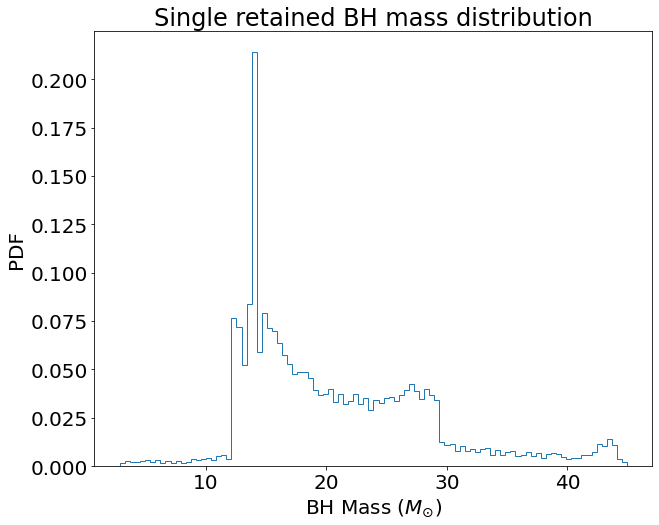

In [24]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.hist(singlesMass, bins=100, histtype='step', density=True)

ax.set_title('Single retained BH mass distribution')
ax.set_xlabel('BH Mass ($M_{\odot}$)')
ax.set_ylabel('PDF')

Text(0, 0.5, 'PDF')

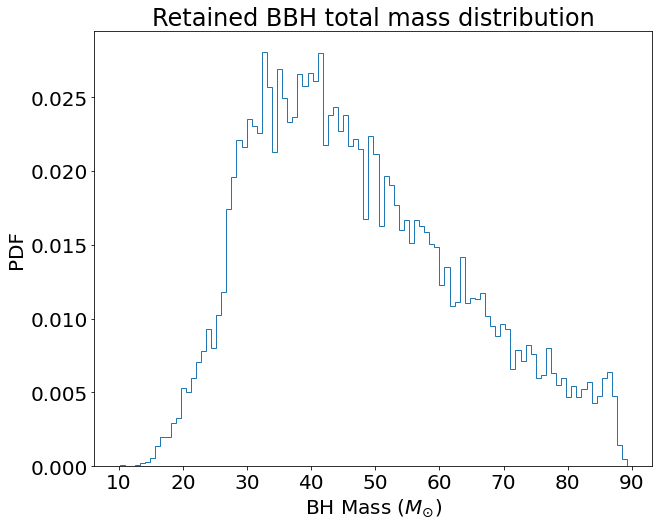

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.hist(BBHRetain['   Mass(CP)   ']+BBHRetain['   Mass(SN)   '], bins=100, histtype='step', density=True)

ax.set_title('Retained BBH total mass distribution')
ax.set_xlabel('BH Mass ($M_{\odot}$)')
ax.set_ylabel('PDF')

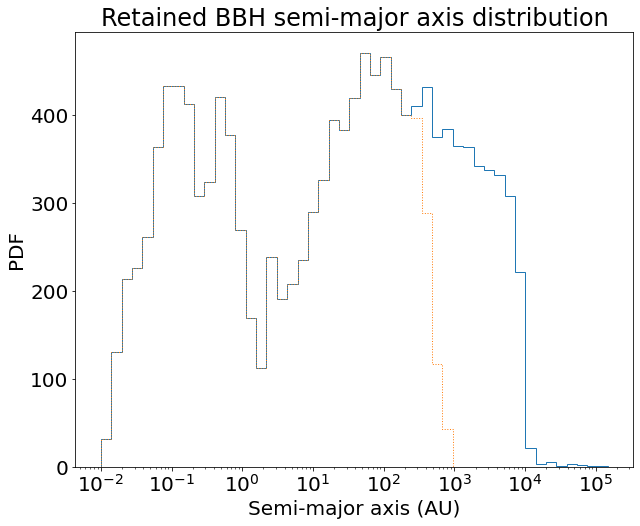

In [26]:
fig, ax = plt.subplots(figsize=(10, 8))

bins = np.logspace(-2, np.log10(1.5e5), 50)

ax.hist(BBHRetain['SemiMajorAxis ']*Rsol2AU, bins=bins, histtype='step')
ax.hist(BBHRetain['SemiMajorAxis '].loc[hard]*Rsol2AU, bins=bins, histtype='step', linestyle=':')

ax.set_title('Retained BBH semi-major axis distribution')
ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel('PDF')
ax.set_xscale('log')

In [27]:
# Properties of these distributions
singleMassMu = np.mean(singlesMass)
BBHMassMu = np.mean(BBHRetain['   Mass(CP)   '].values+BBHRetain['   Mass(SN)   '].values)

Nsingle = len(singlesMass); Nbinary = len(BBHRetain)-1

BBHSemi = BBHRetain['SemiMajorAxis '].values # Rsol


print(f'Nbinaries/Nsingles = {Nbinary/Nsingle}')

Nbinaries/Nsingles = 0.8807710141087634


First just randomly pick a target binary from the retained binary population and then calculate the interaction with every other binary and every single BH

In [28]:
k = 2 # Parameter for setting the interaction rate

# Only take hard binaries
BBHRetainHard = BBHRetain.loc[hard]
BBHRetainHard.reset_index(inplace=True, drop=True)

# Pick target binary
ind = np.random.randint(0, len(BBHRetainHard)) # Random index
targ = BBHRetainHard.loc[ind] # Target binary

proj = BBHRetainHard.drop(ind) # Projectile binaries


# Interaction of target binary with singles
gammaS = np.sum(targ['SemiMajorAxis ']**2 * (1 + (G*(targ['Mtot']+singlesMass))/(k*targ['SemiMajorAxis ']*sigmaREL**2)))

# Interaction of target binary with other binaries
gammaB = np.sum((targ['SemiMajorAxis '] + proj['SemiMajorAxis '].values)**2 * (1 + (G*(targ['Mtot']+proj['Mtot'].values))/(k*(targ['SemiMajorAxis '] + proj['SemiMajorAxis '].values)*sigmaREL**2)))

intRatio = gammaB/gammaS

print(f'The interaction for a target binary is {intRatio:.3g}')

The interaction for a target binary is 49.9


In [31]:
'''
Now have it loop over every single hard binary 
'''

gammaSTot=0
gammaBTot=0

for ind in BBHRetainHard.index:
    # Pick target binary
    targ = BBHRetainHard.loc[ind] # Target binary

    # Finding the index of target so that it doesn't interact with itself
    index = BBHRetain.loc[BBHRetain['    SEED    ']==targ['    SEED    ']].index
    proj = BBHRetain.drop(index) # Projectile binaries

    # Relative vel disp for single projectiles
    sigmaRelSingle = sigmaCL * np.sqrt(1/avgBHMass + singleMassMu/(avgBHMass*targ['Mtot']))
    
    # Relative vel disp for BBH projectiles
    sigmaRelBBH = sigmaCL * np.sqrt(1/avgBHMass + BBHMassMu/(avgBHMass*targ['Mtot']))
    
    # Interaction of target binary with singles
    gammaS = np.sum(targ['SemiMajorAxis ']**2 * (1 + (G*(targ['Mtot']+singlesMass))/(k*targ['SemiMajorAxis ']*sigmaRelSingle**2)))

    # Interaction of target binary with other binaries
    gammaB = np.sum((targ['SemiMajorAxis '] + proj['SemiMajorAxis '].values)**2 * (1 + (G*(targ['Mtot']+proj['Mtot'].values))/(k*(targ['SemiMajorAxis '] + proj['SemiMajorAxis '].values)*sigmaRelBBH**2)))
    
    
    # Add these to the totals 
    gammaSTot+=gammaS
    gammaBTot+=gammaB  
    
    print(f'{ind/len(BBHRetainHard):.0%} Completed', end='\r')
    
# Final interaction ratio
intRatioTot = gammaBTot/gammaSTot

print(f'The ratio of interaction rates with binaries vs singles is {intRatio:.3g}')

The ratio of interaction rates with binaries vs singles is 49.9


Here we are going to take a target binary integrate over the remaining binaries and singles. We then vary the semi-major axis of the target and plot $\frac{\Gamma_{\mathrm{B}}}{\Gamma_{\mathrm{S}}}$ against $a_{\mathrm{t}}$

In [47]:
# Finding the average BH mass
avgBHMass = np.mean(SN['   Mass(SN)   '].loc[SN['Stellar_Type(SN)']==14].values)  

eta=1

# Set esc vel to find vel disp
vesc = 50 # km/s

# Cluster velocity dispersion
sigmaCL = vesc/(np.sqrt(14*(1+eta/avgBHMass))) # km/s
sigmaREL = np.sqrt((2*eta)/avgBHMass) * sigmaCL

# seeds retained from first SN
retainedInFirst = SN1st.loc[(SN1st['SystemicSpeed ']<vesc)&(SN1st['Unbound']==0)]
retainedSN = SN1st.loc[(SN1st['ComponentSpeed(SN)']<vesc)&(SN1st['Unbound']==1)]
retainedCP = SN1st.loc[(SN1st['ComponentSpeed(CP)']<vesc)&(SN1st['Unbound']==1)]

# BBHbound retained after second
index = BBHBound['    SEED    '].isin(retainedInFirst['    SEED    '])
BBHRetain = BBHBound.loc[(BBHBound['SystemicSpeed ']<vesc)&(index)]


# Check if there are any duplicates
if len(BBHRetain)!=len(np.unique(BBHRetain['    SEED    '].values)):
    BBHRetain.drop_duplicates(subset='    SEED    ', inplace=True, keep='last')

BBHRetain.reset_index(inplace=True, drop=True)    
'''
Finding hard binaries
'''
# Reduced Mass
mu  = BBHRetain['   Mass(SN)   ']*BBHRetain['   Mass(CP)   ']/(BBHRetain['   Mass(SN)   ']+BBHRetain['   Mass(CP)   '])

# calculate hard boundary
ah  = (G * mu)/sigmaREL**2 # Rsol

BBHRetain['ah'] = ah

# Define the hard index
hard = BBHRetain['SemiMajorAxis '] < BBHRetain['ah']

# Define binary total mass
Mtot = BBHRetain['   Mass(SN)   '] + BBHRetain['   Mass(CP)   ']
BBHRetain['Mtot'] = Mtot

# Only take hard binaries
BBHRetainHard = BBHRetain.loc[hard]
BBHRetainHard.reset_index(inplace=True, drop=True)

'''
Finding all of the retained singles (we only need to know the masses)
'''
singlesMass = np.array([])

# BBHUnbound on second
index = BBHUnbound['    SEED    '].isin(retainedInFirst['    SEED    '])

singlesMass = np.append(singlesMass, BBHUnbound['   Mass(SN)   '].loc[(index)&(BBHUnbound['ComponentSpeed(SN)']<vesc)].values)
singlesMass = np.append(singlesMass, BBHUnbound['   Mass(CP)   '].loc[(index)&(BBHUnbound['ComponentSpeed(CP)']<vesc)].values)
singlesMass = np.append(singlesMass, retainedSN['   Mass(SN)   '].loc[retainedSN['Stellar_Type(SN)']==14].values)

index = SN2nd['    SEED    '].isin(retainedCP['    SEED    '])
singlesMass = np.append(singlesMass, SN2nd['   Mass(SN)   '].loc[(index)&(SN2nd['ComponentSpeed(SN)']<vesc)&(SN2nd['Stellar_Type(SN)']==14)].values)

# averages of the masses
singleMassMu = np.mean(singlesMass)
BBHMassMu = np.mean(BBHRetain['   Mass(CP)   '].values+BBHRetain['   Mass(SN)   '].values)


'''
Now have it loop over every single hard binary 
'''

# Semi major axis to loop over 
semi = np.logspace(min(np.log10(BBHRetainHard['SemiMajorAxis '].values)), np.log10(max(BBHRetainHard['SemiMajorAxis '].values)), 10000)
mass_target = BBHMassMu # Assume average BBH mass

# Empty arrays to store
intRatioTot=[]
count=0
for a in semi:
    # Define projectile binaries
    proj = BBHRetainHard

    sigmaRelSingle = sigmaCL * np.sqrt((eta/avgBHMass)*(1 + singleMassMu/mass_target))
    # Relative vel disp for BBH projectiles
    sigmaRelBBH = sigmaCL * np.sqrt((eta/avgBHMass)*(1 + BBHMassMu/mass_target))

    # Interaction of target binary with singles
    gammaS = np.sum(a**2 * (1 + (G*(mass_target+singlesMass))/(k*a*sigmaRelSingle**2)))

    # Interaction of target binary with other binaries
    gammaB = np.sum((a + proj['SemiMajorAxis '].values)**2 * (1 + (G*(mass_target+proj['Mtot'].values))/(k*(a + proj['SemiMajorAxis '].values)*sigmaRelBBH**2)))

    # Calculate the interaction rate for this binary
    intRatioTot.append(gammaB/gammaS)

    count+=1
    print(f'{count/len(semi):.0%} Completed', end='\r')

# Final interaction ratio
intRatioTot = np.asarray(intRatioTot)



Text(0, 0.5, '$\\Gamma_{\\mathrm{B}}/\\Gamma_{\\mathrm{S}}$')

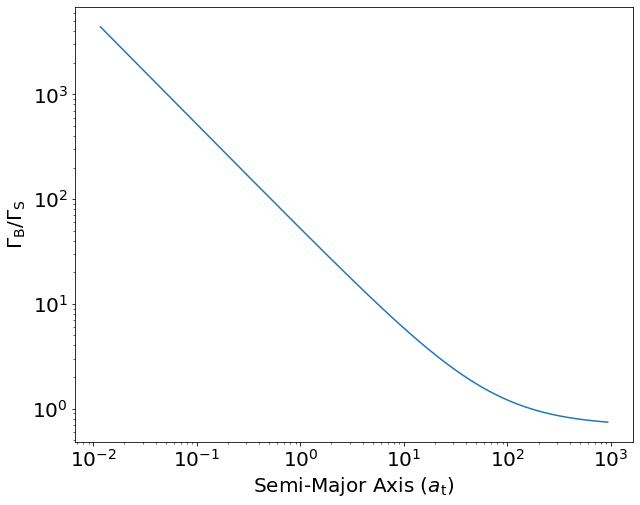

In [48]:
fig, ax = plt.subplots(figsize=(10,8))

ax.loglog(semi*Rsol2AU, intRatioTot)

ax.set_xlabel('Semi-Major Axis ($a_{\mathrm{t}}$)')
ax.set_ylabel('$\Gamma_{\mathrm{B}}/\Gamma_{\mathrm{S}}$')

In [34]:
import pickle as pck

completed vesc = 5 km/s
completed vesc = 10 km/s
completed vesc = 50 km/s
completed vesc = 100 km/s
completed vesc = 500 km/s


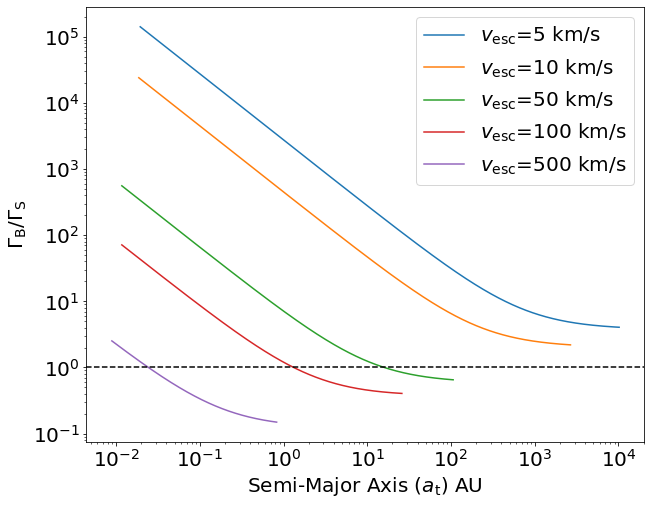

In [52]:
fig, ax = plt.subplots(figsize=(10,8))

# Energy equipartition parameter
eta = 1

# For the system in equilibrium set eta to avgBHMass/1
# eta = avgBHMass/1

# Array of escape velocities
vescArray = np.array([5, 10, 50, 100, 500])

# Hold int data
intData = {}
Nb_Ns = []
for vesc in vescArray:

    # Cluster velocity dispersion
    sigmaCL = vesc/(np.sqrt(14*(1+eta/avgBHMass))) # km/s
    sigmaREL = np.sqrt((2*eta)/avgBHMass) * sigmaCL

    # seeds retained from first SN
    retainedInFirst = SN1st.loc[(SN1st['SystemicSpeed ']<vesc)&(SN1st['Unbound']==0)]
    retainedSN = SN1st.loc[(SN1st['ComponentSpeed(SN)']<vesc)&(SN1st['Unbound']==1)]
    retainedCP = SN1st.loc[(SN1st['ComponentSpeed(CP)']<vesc)&(SN1st['Unbound']==1)]

    # BBHbound retained after second
    index = BBHBound['    SEED    '].isin(retainedInFirst['    SEED    '])
    BBHRetain = BBHBound.loc[(BBHBound['SystemicSpeed ']<vesc)&(index)]


    # Check if there are any duplicates
    if len(BBHRetain)!=len(np.unique(BBHRetain['    SEED    '].values)):
        BBHRetain.drop_duplicates(subset='    SEED    ', inplace=True, keep='last')

    BBHRetain.reset_index(inplace=True, drop=True)    
    '''
    Finding hard binaries
    '''
    # Reduced Mass
    mu  = BBHRetain['   Mass(SN)   ']*BBHRetain['   Mass(CP)   ']/(BBHRetain['   Mass(SN)   ']+BBHRetain['   Mass(CP)   '])

    # calculate hard boundary
    ah  = (G * mu)/sigmaREL**2 # Rsol

    BBHRetain['ah'] = ah

    # Define the hard index
    hard = BBHRetain['SemiMajorAxis '] < BBHRetain['ah']

    # Define binary total mass
    Mtot = BBHRetain['   Mass(SN)   '] + BBHRetain['   Mass(CP)   ']
    BBHRetain['Mtot'] = Mtot
    
    # Only take hard binaries
    BBHRetainHard = BBHRetain.loc[hard]
    BBHRetainHard.reset_index(inplace=True, drop=True)
    
    '''
    Finding all of the retained singles (we only need to know the masses)
    '''
    singlesMass = np.array([])

    # BBHUnbound on second
    index = BBHUnbound['    SEED    '].isin(retainedInFirst['    SEED    '])

    singlesMass = np.append(singlesMass, BBHUnbound['   Mass(SN)   '].loc[(index)&(BBHUnbound['ComponentSpeed(SN)']<vesc)].values)
    singlesMass = np.append(singlesMass, BBHUnbound['   Mass(CP)   '].loc[(index)&(BBHUnbound['ComponentSpeed(CP)']<vesc)].values)
    singlesMass = np.append(singlesMass, retainedSN['   Mass(SN)   '].loc[retainedSN['Stellar_Type(SN)']==14].values)

    index = SN2nd['    SEED    '].isin(retainedCP['    SEED    '])
    singlesMass = np.append(singlesMass, SN2nd['   Mass(SN)   '].loc[(index)&(SN2nd['ComponentSpeed(SN)']<vesc)&(SN2nd['Stellar_Type(SN)']==14)].values)

    # averages of the masses
    singleMassMu = np.mean(singlesMass)
    BBHMassMu = np.mean(BBHRetain['   Mass(CP)   '].values+BBHRetain['   Mass(SN)   '].values)


    '''
    Now have it loop over every single hard binary 
    '''
    # Semi major axis to loop over 
    semi = np.logspace(min(np.log10(BBHRetainHard['SemiMajorAxis '].values)), np.log10(max(BBHRetainHard['SemiMajorAxis '].values)), 10000)
    mass_target = BBHMassMu # Assume average BBH mass

    # Empty arrays to store
    GB = []
    GS = []
    
    intRatioTot=[]
    count=0
    for a in semi:
        # Define projectile binaries
        proj = BBHRetainHard

        # Relative vel disp for single projectiles
        sigmaRelSingle = sigmaCL * np.sqrt((eta/avgBHMass)*(1 + singleMassMu/mass_target))

        # Relative vel disp for BBH projectiles
        sigmaRelBBH = sigmaCL * np.sqrt((eta/avgBHMass)*(1 + BBHMassMu/mass_target))

        # Interaction of target binary with singles
        gammaS = np.sum(a**2 *sigmaRelSingle* (1 + (G*(mass_target+singlesMass))/(k*a*sigmaRelSingle**2)))

        # Interaction of target binary with other binaries
        gammaB = np.sum((a + proj['SemiMajorAxis '].values)**2 *sigmaRelBBH* (1 + (G*(mass_target+proj['Mtot'].values))/(k*(a + proj['SemiMajorAxis '].values)*sigmaRelBBH**2)))

        # Calculate the interaction rate for this binary
        intRatioTot.append(gammaB/gammaS)

        GB.append(gammaB)
        GS.append(gammaS)
        
        count+=1
        print(f'{count/len(semi):.0%} Completed', end='\r')

    # Final interaction ratio
    intRatioTot = np.asarray(intRatioTot)
    GB = np.asarray(GB)
    GS = np.asarray(GS)
    
    # Save to dictionary
    intData[vesc] = np.vstack((semi, intRatioTot)).T
    
    # number ratio
    Nb_Ns.append(len(BBHRetainHard)/len(singlesMass))
    
    # Plotting int ratio against semi Major axis
    ax.loglog(semi*Rsol2AU, intRatioTot, label='$v_{{\mathrm{{esc}}}}$={} km/s'.format(vesc))
    
    print(f'completed vesc = {vesc} km/s')

with open(os.path.join(dataDir, 'IntRatioVesc.pkl'), 'wb') as f:
    pck.dump(intData, f)
    
# Int rate = 1
ax.axhline(1, 0, 1, linestyle='--', color='black')
    
# ax.set_xlim(10, None)
ax.set_xlabel('Semi-Major Axis ($a_{\mathrm{t}}$) AU ')
ax.set_ylabel('$\Gamma_{\mathrm{B}}/\Gamma_{\mathrm{S}}$')
# ax.set_ylabel('$\Gamma_{\mathrm{S}}/(\Gamma_{\mathrm{S}}+\Gamma_{\mathrm{B}})$')

ax.legend()

In [16]:
print(Nb_Ns); print(sigmaRelBBH/sigmaRelSingle)

[19.021505376344088, 2.4363277393879565, 0.3811291267825747, 0.15346148389842532, 0.04909495331584065]
1.2334263791227702


completed Mtot = 20 Msol
completed Mtot = 40 Msol
completed Mtot = 60 Msol
completed Mtot = 80 Msol


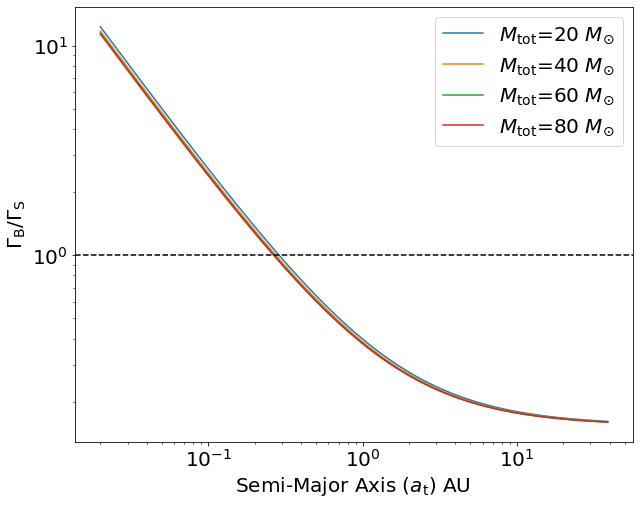

In [17]:
'''
I want to see how dependent it is on the mass of the target
'''

fig, ax = plt.subplots(figsize=(10,8))
for mass in[20, 40, 60, 80]:
    
    vesc=100 # km/s
    
    # Cluster velocity dispersion
    sigmaCL = vesc/(np.sqrt(14*(1+1/avgBHMass))) # km/s
    sigmaREL = np.sqrt(2/avgBHMass) * sigmaCL
    # seeds retained from first SN
    retainedInFirst = SN1st.loc[(SN1st['SystemicSpeed ']<vesc)&(SN1st['Unbound']==0)]
    retainedSN = SN1st.loc[(SN1st['ComponentSpeed(SN)']<vesc)&(SN1st['Unbound']==1)]
    retainedCP = SN1st.loc[(SN1st['ComponentSpeed(CP)']<vesc)&(SN1st['Unbound']==1)]
    # BBHbound retained after second
    index = BBHBound['    SEED    '].isin(retainedInFirst['    SEED    '])
    BBHRetain = BBHBound.loc[(BBHBound['SystemicSpeed ']<vesc)&(index)]
    # Check if there are any duplicates
    if len(BBHRetain)!=len(np.unique(BBHRetain['    SEED    '].values)):
        BBHRetain.drop_duplicates(subset='    SEED    ', inplace=True, keep='last')
    BBHRetain.reset_index(inplace=True, drop=True)    
    '''
    Finding hard binaries
    '''
    # Reduced Mass
    mu  = BBHRetain['   Mass(SN)   ']*BBHRetain['   Mass(CP)   ']/(BBHRetain['   Mass(SN)   ']+BBHRetain['   Mass(CP)   '])
    # calculate hard boundary
    ah  = (G * mu)/sigmaREL**2 # Rsol
    BBHRetain['ah'] = ah
    # Define the hard index
    hard = BBHRetain['SemiMajorAxis '] < BBHRetain['ah']
    # Define binary total mass
    Mtot = BBHRetain['   Mass(SN)   '] + BBHRetain['   Mass(CP)   ']
    BBHRetain['Mtot'] = Mtot
    
    # Only take hard binaries
    BBHRetainHard = BBHRetain.loc[hard]
    BBHRetainHard.reset_index(inplace=True, drop=True)
    
    '''
    Finding all of the retained singles (we only need to know the masses)
    '''
    singlesMass = np.array([])
    # BBHUnbound on second
    index = BBHUnbound['    SEED    '].isin(retainedInFirst['    SEED    '])
    singlesMass = np.append(singlesMass, BBHUnbound['   Mass(SN)   '].loc[(index)&(BBHUnbound['ComponentSpeed(SN)']<vesc)].values)
    singlesMass = np.append(singlesMass, BBHUnbound['   Mass(CP)   '].loc[(index)&(BBHUnbound['ComponentSpeed(CP)']<vesc)].values)
    singlesMass = np.append(singlesMass, retainedSN['   Mass(SN)   '].loc[retainedSN['Stellar_Type(SN)']==14].values)
    index = SN2nd['    SEED    '].isin(retainedCP['    SEED    '])
    singlesMass = np.append(singlesMass, SN2nd['   Mass(SN)   '].loc[(index)&(SN2nd['ComponentSpeed(SN)']<vesc)&(SN2nd['Stellar_Type(SN)']==14)].values)
    # averages of the masses
    singleMassMu = np.mean(singlesMass)
    BBHMassMu = np.mean(BBHRetain['   Mass(CP)   '].values+BBHRetain['   Mass(SN)   '].values)
    
    '''
    Now have it loop over every single hard binary 
    '''
    # Semi major axis to loop over 
    semi = np.logspace(min(np.log10(BBHRetainHard['SemiMajorAxis '].values)), np.log10(max(BBHRetainHard['SemiMajorAxis '].values)), 10000)
#     mass = BBHMassMu # Assume average BBH mass
    # Empty arrays to store
    intRatioTot=[]
    count=0
    for a in semi:
        # Define projectile binaries
        proj = BBHRetainHard
        # Relative vel disp for single projectiles
        sigmaRelSingle = sigmaCL * np.sqrt(1/avgBHMass + singleMassMu/(avgBHMass*mass))
        # Relative vel disp for BBH projectiles
        sigmaRelBBH = sigmaCL * np.sqrt(1/avgBHMass + BBHMassMu/(avgBHMass*mass))
        # Interaction of target binary with singles
        gammaS = np.sum(a**2 * (1 + (G*(mass+singlesMass))/(k*a*sigmaRelSingle**2)))
        # Interaction of target binary with other binaries
        gammaB = np.sum((a + proj['SemiMajorAxis '].values)**2 * (1 + (G*(mass+proj['Mtot'].values))/(k*(a + proj['SemiMajorAxis '].values)*sigmaRelBBH**2)))
        # Calculate the interaction rate for this binary
        intRatioTot.append(gammaB/gammaS)
        count+=1
        print(f'{count/len(semi):.0%} Completed', end='\r')
    # Final interaction ratio
    intRatioTot = np.asarray(intRatioTot)
    # Plotting int ratio against semi Major axis
    ax.loglog(semi*Rsol2AU, intRatioTot, label='$M_{{\mathrm{{tot}}}}$={} $M_{{\odot}}$'.format(mass))
    print(f'completed Mtot = {mass} Msol')
    
# Int rate = 1
ax.axhline(1, 0, 1, linestyle='--', color='black')
    
# ax.set_xlim(10, None)
ax.set_xlabel('Semi-Major Axis ($a_{\mathrm{t}}$) AU ')
ax.set_ylabel('$\Gamma_{\mathrm{B}}/\Gamma_{\mathrm{S}}$')
ax.legend()